# Latent Dirichlet Allocation using TensorFlow (Batch VB)


### Latent Dirichlet Allocation model:

 - $\theta_{d=1,...,M} \sim \mathrm{Dir}_K(\alpha)$
 - $\beta_{k=1,...,K} \sim \mathrm{Dir}_V(\eta)$
 - $z_{d=1,...,M,i=1,...,N_d} \sim \mathrm{Multinomial}_{ \ K}(\theta_d)$
 - $w_{d=1,...,M,i=1,...,N_d} \sim \mathrm{Multinomial}_{ \ V}(\beta_{z_{di}})$



where

 - $V$ is a vocabulary size
 - $K$ is a number of topics
 - $\eta$ is the parameter of the Dirichlet prior on the per-topic word distribution (known and symetric)
 - $\alpha$ is the parameter of the Dirichlet prior on the per-document topic distributions (known and symetric)
 - $\theta_d$ is the topic distribution for document d
 - $\beta_k$ is the word distribution for topic k
 - $z_{di}$ is the topic for the i-th word in document d
 - $w_{di}$ is a specific word from d-th document belonging to $V$

In plate notation:

![hustlin_erd](LDA_plate_notation.png)

### Posterior distributions:

We assume full factorial design:


$$q(z, \beta, \theta) = \prod_d \prod_i q(z_{di}) \times \prod_d q(\theta_d) \times \prod_k q(\beta_k)$$

where

- $q(z_{di}) = p(z_{di}|\phi) = \mathrm{Multinomial}_{ \ K}(\phi_{dw_{di}}) $
- $q(\theta_d) = p(\theta_d|\gamma) = \mathrm{Dir}_{K}(\gamma_{d}) $
- $q(\beta_k) = p(\beta_k|\lambda) = \mathrm{Dir}_{V}(\lambda_{k}) $

### Parameters Tensors:

*Vocabulary to topic membership:*

$$ \phi = \phi_{d=1,...,D, \ v=1,...,V, \ k=1,...,K} \in \mathbb{R}_{+}^{D \times V \times K}$$
$ \forall_{d \in 1,...,D} \ \phi_d $ is a *stochastic matrix*.

*Distribution of topics:*
$$ \gamma = \gamma_{d=1,...,D, \ k=1,...,K} \in \mathbb{R}_{+}^{D \times K}$$

*Within topic vocabulary profile:*

$$ \lambda = \lambda_{k=1,...,K \ v=1,...,V} \in \mathbb{R}_{+}^{K \times V} $$

### ELBO:

From the definition of the **E**vidence **L**ower **Bo**und:

$$ \mathcal{L}(w, \phi, \gamma, \lambda) := \mathbb{E}_{z, \theta, \beta}\left[\log p(w, z, \theta, \beta| \alpha, \eta) \right] - \mathbb{E}_{z, \theta, \beta}\left[\log q(z, \theta, \beta) \right]$$

Using the probability factorization of the LDA model

$$ \log p(w, z, \theta, \beta| \alpha, \eta) = \log p(w|z, \beta) p(z|\theta) p(\theta | \alpha) p(\beta | \eta) = $$

$$ = \log \left( \prod_{k=1}^K p(\beta_k|\eta) \times \prod_{d=1}^D p(\theta_d|\alpha) \times \prod_{d=1}^{D} \prod_{i=1}^{N_d} p(w_{di}|\beta_{z_{di}}) p(z_{di}|\theta_d) \right) = $$

$$ =  \sum_{k=1}^K \log p(\beta_k|\eta) +  \sum_{d=1}^D \log p(\theta_d|\alpha) + \sum_{d=1}^{D} \sum_{i=1}^{N_d} \log p(w_{di}|\beta_{z_{di}}) p(z_{di}|\theta_d) = $$

$$ =  \sum_{k=1}^K \log p(\beta_k|\eta) +  \sum_{d=1}^D \left( \log p(\theta_d|\alpha) + \sum_{i=1}^{N_d} \log p(w_{di}|\beta_{z_{di}}) p(z_{di}|\theta_d) \right) = $$

$$ =  \sum_{d=1}^D \left( \log p(\theta_d|\alpha) + \sum_{i=1}^{N_d} \log \left( p(w_{di}|\beta_{z_{di}}) p(z_{di}|\theta_d) \right) + \frac{1}{D} \sum_{k=1}^K \log p(\beta_k|\eta) \right) $$


Taking the expectations with respect to the posterior distribution results in:

$$ \mathbb{E}_{\theta} \left[ \log p(\theta_d|\alpha) \right] = C_1(\alpha) + \sum_{k=1}^K (\alpha_k - 1) \mathbb{E}_{\theta} \left[ \log \theta_{dk} \right] $$

$$ \mathbb{E}_{z, \beta} \left[ \log p(w_{di}|\beta_{z_{di}}) \right] =  \mathbb{E}_{z, \beta} \left[ \log \beta_{z_{di} i} \right] = \sum_{k=1}^{K} \phi_{dw_{di}k} \mathbb{E}_{\beta} \left[ \log \beta_{k i} \right] $$

$$ \mathbb{E}_{z, \theta} \left[ \log p(z_{di}|\theta_d) \right] =  \sum_{k=1}^{K} \phi_{dw_{di}k} \mathbb{E}_{\theta} \left[ \log \theta_{d k} \right] $$

$$ \mathbb{E}_{\beta} \left[ \log p(\beta_{k}|\eta) \right] = C_2(\eta) + \sum_{v=1}^{V} (\eta_v - 1) \mathbb{E}_{\beta} \left[ \log \beta_{kv} \right] $$

For the entropy of the posterior distribution we have:

$$ \log\left(\prod_{d=1}^{D} \prod_{i=1}^{N_{d}} q(z_{di}) \times \prod_{d=1}^D q(\theta_d) \times \prod_{k=1}^{K} q(\beta_k)\right) =  $$

$$ = \sum_{d=1}^{D} \left( \sum_{i=1}^{N_{d}} \log q(z_{di}) + \log q(\theta_d) + \frac{1}{D} \sum_{k=1}^{K} \log q(\beta_k)\right) $$

and expectations with respect to the posterior distribution:

$$ \mathbb{E}_{z} \left[ \log q(z_{di})  \right] = \mathbb{E}_{z_{di}} \left[ \mathbb{1}_{[z_{di}=k]} \log \phi_{dw_{di}k}  \right] = \sum_{k=1}^{K} \phi_{dw_{di}k} \log \phi_{dw_{di}k} $$

$$ \mathbb{E}_{\theta} \left[ \log q(\theta_d)  \right] = \mathbb{E}_{\theta} \left[ \log \frac{1}{B(\gamma_d)} \prod_{k=1}^{K} \theta_{dk}^{\gamma_{dk} - 1} \right] = -\log B(\gamma_d) + \sum_{k=1}^K (\gamma_{dk} - 1)\mathbb{E}_{\theta} \left[ \log \theta_{dk} \right]$$

$$ \mathbb{E}_{\beta}\left[ \log q(\beta_k) \right] = -\log B(\lambda_k) + \sum_{v=1}^V (\lambda_{kv} - 1)\mathbb{E}_{\beta} \left[ \log \beta_{kv} \right]$$

*We should then be able to collapse ELBO to the formula based on counts of words rather than words from documents. This will show that the LDA model is fixed size method.* 

*"When training an LDA model, you start with a collection of documents and each of these is represented by a fixed-length vector (bag-of-words). LDA is a general Machine Learning (ML) technique, which means that it can also be used for other unsupervised ML problems where the input is a collection of fixed-length vectors and the goal is to explore the structure of this data."* (Data Camp)

Grouping terms by corresponding parameters we get:

#### Document vocabulary membership

$$ \mathcal{L}_{[\phi_{dv}]} = \sum_{d=1}^{D} \sum_{i=1}^{N_d} \sum_{k=1}^K \phi_{dw_{di}k} \left( \mathbb{E}_{\beta} \left[ \log \beta_{k i} \right] + \mathbb{E}_{\theta} \left[ \log \theta_{d k} \right] - \log \phi_{dw_{di}k}  \right) = $$

$$ = \sum_{d=1}^{D} \sum_{v=1}^{V} \sum_{k=1}^K n_{dv} \phi_{dvk} \left( \mathbb{E}_{\beta} \left[ \log \beta_{k v} \right] + \mathbb{E}_{\theta} \left[ \log \theta_{d k} \right] - \log \phi_{dvk}  \right)$$

where $n_{dv}$ is a number of times word $v$ from vocabulary $V$ was counted in document $d$.

#### Distribution of topics

$$ \mathcal{L}_{[\gamma_{d}]} = \sum_{d=1}^{D} \sum_{k=1}^K \left\{ (\alpha_k - 1) \mathbb{E}_{\theta} \left[ \log \theta_{dk} \right] + \log B(\gamma_d) - (\gamma_{dk} - 1)\mathbb{E}_{\theta} \left[ \log \theta_{dk} \right] \right\} = $$

$$ = \sum_{d=1}^{D} \sum_{k=1}^K \left\{ (\alpha_k - \gamma_{dk}) \mathbb{E}_{\theta} \left[ \log \theta_{dk} \right] + \frac{1}{K} \log B(\gamma_d) \right\}$$

#### Topic vocabulary profile

$$ \frac{1}{D} \sum_{d=1}^{D} \sum_{v=1}^{V} \sum_{k=1}^K \left\{ (\eta_v - \lambda_{kv}) \mathbb{E}_{\beta} \left[ \log \beta_{k} \right] + \frac{1}{V} \log B(\lambda_k) \right\}$$

### Coordinate ascent optimization

Optimizing for every document and vocabulary entry separately we get:

#### Document vocabulary membership:

$$ \mathrm{argmax}_{\phi_{dv} \in \Delta^{K-1}} \mathcal{L}_{[\phi_{dv}]} =  \mathrm{argmax}_{\phi_{dv} \in \Delta^{K-1}} \sum_{k=1}^K n_{dv} \phi_{dvk} \left( \mathbb{E}_{\beta} \left[ \log \beta_{k v} \right] + \mathbb{E}_{\theta} \left[ \log \theta_{d k} \right] - \log \phi_{dvk}  \right) = $$

$$ =\mathrm{argmax}_{\phi_{dv} \in \mathbb{R}_{+}^K} \sum_{k=1}^K n_{dv} \phi_{dvk} \left( \mathbb{E}_{\beta} \left[ \log \beta_{k v} \right] + \mathbb{E}_{\theta} \left[ \log \theta_{d k} \right] - \log \phi_{dvk}  \right) + \xi (\sum_{k=1}^K \phi_{dvk} - 1) = \Psi(\phi_{dv}, \xi) $$

$$ \frac{\partial}{\partial \phi_{dvk}} \Psi(\phi_{dv}, \xi) = n_{dv} \left( \mathbb{E}_{\beta} \left[ \log \beta_{k v} \right] + \mathbb{E}_{\theta} \left[ \log \theta_{d k} \right] - \log \phi_{dvk} - 1 \right) + \xi $$

$$ \frac{\partial}{\partial \xi} \Psi(\phi_{dv}, \xi) = \sum_{k=1}^K \phi_{dvk} - 1 $$

$$ \frac{\partial}{\partial \phi_{dvk}} \Psi(\phi_{dv}, \xi) = 0 \iff n_{dv} \left( \mathbb{E}_{\beta} \left[ \log \beta_{k v} \right] + \mathbb{E}_{\theta} \left[ \log \theta_{d k} \right] - \log \phi_{dvk} - 1 \right) + \xi = 0 \iff $$

$$ \iff \mathbb{E}_{\beta} \left[ \log \beta_{k v} \right] + \mathbb{E}_{\theta} \left[ \log \theta_{d k} \right] - \log \phi_{dvk} - 1 + \xi' = 0 \iff $$

$$ \iff \log \phi_{dvk} = \mathbb{E}_{\beta} \left[ \log \beta_{k v} \right] + \mathbb{E}_{\theta} \left[ \log \theta_{d k} \right] - 1 + \xi'  \iff $$

$$ \iff \phi_{dvk} \propto \exp \left\{ \mathbb{E}_{\beta} \left[ \log \beta_{k v} \right] + \mathbb{E}_{\theta} \left[ \log \theta_{d k} \right] \right\} $$

#### Doucuments' distribution of topics

Since

$$ \mathbb{E}_{\theta} \left[ \log \theta_{dk} \right] = \psi(\gamma_{dk}) - \psi(\sum_{k=1}^K\gamma_{dk})$$

and

$$ \log B(\gamma_d) = \log \frac{\prod_{k=1}^{K}\Gamma(\gamma_{dk})}{\Gamma ({\sum_{k=1}^K \gamma_{dk}})} = \sum_{k=1}^{K}\log \Gamma (\gamma_{dk}) - \log \Gamma ({\sum_{k=1}^K \gamma_{dk}})$$

$$ \mathrm{argmax}_{\gamma_{d} \in \mathbb{R}_{+}^{K}} \mathcal{L}_{[\gamma_{d}]} = \mathrm{argmax}_{\gamma_{d} \in \mathbb{R}_{+}^{K}} \sum_{k=1}^K \left\{ (\alpha_k - \gamma_{dk} + \sum_{v=1}^V n_{dv} \phi_{dvk}) \mathbb{E}_{\theta} \left[ \log \theta_{dk} \right] \right\} + \log B(\gamma_d) = $$

$$ = \mathrm{argmax}_{\gamma_{d} \in \mathbb{R}_{+}^{K}} \sum_{k=1}^K \left\{ (\alpha_k - \gamma_{dk} + \sum_{v=1}^V n_{dv} \phi_{dvk}) (\psi(\gamma_{dk}) - \psi(\sum_{k=1}^K\gamma_{dk})) \right\} + \sum_{k=1}^{K}\log \Gamma (\gamma_{dk}) - \log \Gamma ({\sum_{k=1}^K \gamma_{dk}}) = \Psi(\gamma_d)$$

$$ \frac{\partial}{\partial \gamma_{dj}} \Psi(\gamma_d) = -\psi(\gamma_{dj}) + \psi({\sum_k \gamma_{dk})} + \sum_{k=1}^K \left\{ (\alpha_k - \gamma_{dk} + \sum_{v=1}^V n_{dv} \phi_{dvk})*(\psi'(\gamma_{dj})*1_{k=j} - \psi'(\sum_{k=1}^K\gamma_{dk})) \right\} + \psi(\gamma_{dj}) - \psi(\sum_k \gamma_{dk}) = $$

$$ = \sum_{k=1}^K \left\{ (\alpha_k - \gamma_{dk} + \sum_{v=1}^V n_{dv} \phi_{dvk})*(\psi'(\gamma_{dj})*1_{k=j} - \psi'(\sum_{k=1}^K\gamma_{dk})) \right\} $$

Since *trigamma* function has no real roots it follows that:

$$ \frac{\partial}{\partial \gamma_{dj}} \Psi(\gamma_d) = 0 \iff \forall_{k} \ \ \  \alpha_k - \gamma_{dk} + \sum_{v=1}^V n_{dv} \phi_{dvk} = 0 \iff $$

$$ \iff   \gamma_{dk} = \alpha_k  + \sum_{v=1}^V n_{dv} \phi_{dvk} $$

#### Topic vocabulary profile (M-Step)

Exact derivation as for the $\gamma_d$ gives an update equation for $\lambda_k$

$$ \lambda_{kv} = \eta_v + \sum_{d=1}^D n_{dv}\phi_{dvk} $$

### Final algorithm

 - initialize $\lambda$ and $\gamma$
 - while improvement $ \mathcal{L}(w, \phi, \gamma, \lambda) > 1e-6$ 
     - while $\gamma$ changes:
         - for $d = 1,...,D$
         - $\phi_{dvk} \propto \exp \left\{ \mathbb{E}_{\beta} \left[ \log \beta_{k v} \right] + \mathbb{E}_{\theta} \left[ \log \theta_{d k} \right] \right\}$
         - $\gamma_{dk} = \alpha  + \sum_{v=1}^V n_{dv} \phi_{dvk}$
     - $\lambda_{kv} = \eta_v + \sum_{d=1}^D n_{dv}\phi_{dvk}$

## Tensorflow Static Graph Declaration

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(tf.__git_version__)

1.6.0
v1.6.0-0-gd2e24b6039


In [2]:
x = tf.Variable(initial_value=10.0)
y = tf.placeholder(dtype=tf.float32)
res = x + y

print(res)

Tensor("add:0", dtype=float32)


In [3]:
# feed data and run TF graph
with tf.Session() as sees:
    tf.global_variables_initializer().run()
    print(sees.run(res, feed_dict={y: 3.0}))
    print(sees.run(res, feed_dict={y: 2.0}))

13.0
12.0


In [4]:
print(res)

Tensor("add:0", dtype=float32)


## Tensorflow Eager Execution Mode

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(tf.__git_version__)

1.6.0
v1.6.0-0-gd2e24b6039


In [2]:
import tensorflow.contrib.eager as tfe
tfe.enable_eager_execution()

In [3]:
x = tfe.Variable(initial_value=10.0)
y = 3.0

print(x + y)

tf.Tensor(13.0, shape=(), dtype=float32)


In [4]:
(x + y).numpy()

13.0

## Case Study: Synthetic DataSet

In [5]:
import pandas as pd

In [6]:
# set data dimensions
K = 3
V = 10
D = 1000
N = 100

# set the seed
np.random.seed(2014)

# beta prior parameters
eta = np.ones(V) * 1e-1

# beta profiles
beta = np.random.dirichlet(alpha=eta, size=K)

# theta prior parameters
alpha = np.ones(K) * 1e-1
# alpha[0] = 10

# document's prior topic allocation
theta = np.random.dirichlet(alpha=alpha, size=D)

# word's topic membership
z = [np.random.choice(K, size=N, replace=True, p=theta[d, :]) for d in range(D)]
z = np.vstack(z)

# actual words and counts
w = [np.array([np.random.choice(V, size=1, p=beta[k,:])[0] for k in z[d, :]]  + list(range(V))) for d in range(D)]
nw = [np.unique(w[d], return_counts=True)[1] for d in range(D)]
nw = np.vstack(nw) - 1.0
w = np.vstack(w)

nw = tf.convert_to_tensor(nw, dtype=tf.float32)
nw = tfe.Variable(initial_value=tf.transpose(nw),
                 name="nw_vd")

nw_kvd = tf.tile(tf.expand_dims(nw / tf.reduce_sum(nw), axis=0), 
                 multiples=[K, 1, 1])

In [7]:
print("beta:")
pd.DataFrame(np.round(np.transpose(beta), decimals=3))

beta:


,0,1,2
0,0.000,0.579,0.041
1,0.000,0.010,0.000
2,0.000,0.000,0.000
3,0.063,0.003,0.001
4,0.000,0.033,0.460
5,0.927,0.006,0.079
6,0.001,0.363,0.000
7,0.008,0.000,0.086
8,0.000,0.000,0.333
9,0.000,0.006,0.000


In [8]:
print("theta:")
pd.DataFrame(np.round(theta, decimals=3)).head(6)

theta:


,0,1,2
0,0.215,0.002,0.782
1,0.000,0.000,1.000
2,0.739,0.261,0.000
3,0.047,0.535,0.418
4,0.240,0.000,0.760
5,0.981,0.019,0.000


In [9]:
print("documents word counts:")
pd.DataFrame(tf.transpose(nw).numpy()).head(6)

documents word counts:


,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,2.0,33.0,31.0,0.0,5.0,29.0,0.0
1,7.0,0.0,0.0,0.0,40.0,9.0,0.0,12.0,32.0,0.0
2,14.0,0.0,0.0,6.0,1.0,68.0,9.0,2.0,0.0,0.0
3,29.0,1.0,0.0,0.0,25.0,7.0,22.0,4.0,12.0,0.0
4,4.0,0.0,0.0,0.0,42.0,17.0,0.0,10.0,27.0,0.0
5,0.0,0.0,0.0,6.0,0.0,94.0,0.0,0.0,0.0,0.0


### Tensorflow model

 - initialize parameters
 - updating functions:
     - update gamma
     - upate phi (with e_log_beta, e_log_theta)
     - update lambda
 - main unction (alternating E and M step)
 

In [10]:
# initialize LDA parameters
def initialize_variables(K, V, D, alpha=1e-3, eta=1e-3, seed=2014):
    """
    Initialize parameters of LDA model returning adequate Tensors.

    args:
    
        K (int): number of LDA components 
        V (int): vocabulary size
        D (int): number of documents
        alpha (float): hyperparameter for theta prior
        eta (float): hyperparameter for beta prior
       
       
    returns:
    
        eta: [V] tensor with prior parameters (alpha) for beta
        lambda: [K, V] tensor with posterior word distribution per class
        phi: [K, V, D] tensor with vocabulary membership per document
        gamma: [K, D] tensor
        
    """
    tf.set_random_seed(seed)
    eta = tfe.Variable(initial_value=tf.ones(V) * eta, 
                       name="eta_v")
    alpha = tfe.Variable(initial_value=tf.ones(K) * alpha, 
                         name="alpha_k")    
    lam = tfe.Variable(initial_value=tf.abs(tf.random_normal(shape=(K, V))), 
                       name="lambda_kv")
    
    phi = tfe.Variable(initial_value=tf.random_normal(shape=(K, V, D)), 
                       name="phi_kvd")
    tf.assign(ref=phi, value=tf.nn.softmax(phi, axis=0))
    
    gamma = tfe.Variable(initial_value=tf.abs(tf.random_normal(shape=(K, D))), 
                        name="gamma_kd")
    
    e_log_beta = tfe.Variable(initial_value=tf.abs(tf.random_normal(shape=(K, V, D))) * .0, 
                        name="e_log_beta_kvd")
    
    e_log_theta = tfe.Variable(initial_value=tf.abs(tf.random_normal(shape=(K, V, D))) * .0, 
                        name="e_log_theta_kvd")
    
    return eta, alpha, lam, phi, gamma, e_log_beta, e_log_theta


#### lambda update:

$$\lambda_{kv} = \eta_v + \sum_{d=1}^D n_{dv}\phi_{dvk}$$

In [11]:
def update_lambda(lam, eta, phi, nw):
    
    K = lam.shape.as_list()[0]
    for k in range(K):
        tf.scatter_update(ref=lam, 
                  indices=k, 
                  updates=tf.reduce_sum(tf.multiply(phi[k], nw), axis=1) + eta)
        
    return lam


#### gamma update:

$$\gamma_{dk} = \alpha  + \sum_{v=1}^V n_{dv} \phi_{dvk}$$

In [12]:
# gamma update
def update_gamma(gamma, alpha, phi, nw):
    
    K = gamma.shape.as_list()[0]
    for k in range(K):
        tf.scatter_update(ref=gamma, 
                  indices=k, 
                  updates=tf.reduce_sum(tf.multiply(phi[k], nw), axis=0) + alpha[k])

        
    return gamma

#### e_log_beta update:

$$ \mathbb{E}_{\beta} \left[ \log \beta_{k v} \right]  = \psi(\lambda_{kv}) - \psi(\sum_{v=1}^V \lambda_{kv}) $$

In [13]:
def update_e_log_beta(e_log_beta, lam):
    
    K = lam.shape.as_list()[0]
    for k in range(K):
        tf.scatter_update(ref=e_log_beta,
                  indices=k,
                  updates=tf.tile(tf.expand_dims(tf.digamma(lam[k]) - tf.digamma(tf.reduce_sum(lam[k])), axis=1), multiples=[1, D]))
    
    return e_log_beta


#### e_log_theta update:

$$ \mathbb{E}_{\theta} \left[ \log \theta_{dk} \right] = \psi(\gamma_{dk}) - \psi(\sum_{k=1}^K\gamma_{dk})$$

In [14]:
def update_e_log_theta(e_log_theta, gamma):
    
    tf.assign(ref=e_log_theta, 
              value=tf.tile(tf.expand_dims(tf.digamma(gamma) - tf.digamma(tf.reduce_sum(gamma, axis=0)), axis=1), multiples=[1, V, 1]))

    return e_log_theta


#### phi update:

$$ \phi_{dvk} \propto \exp \left\{ \mathbb{E}_{\beta} \left[ \log \beta_{k v} \right] + \mathbb{E}_{\theta} \left[ \log \theta_{d k} \right] \right\} $$

In [15]:
def update_phi(e_log_beta, e_log_theta):
    tf.assign(ref=phi, 
              value=e_log_beta + e_log_theta)
    tf.assign(ref=phi, value=tf.nn.softmax(logits=phi, axis=0))
    
    return phi


### ELBO

$$ A := \sum_{d=1}^{D} \sum_{v=1}^{V} \sum_{k=1}^K n_{dv} \phi_{dvk} \left( \mathbb{E}_{\beta} \left[ \log \beta_{k v} \right] + \mathbb{E}_{\theta} \left[ \log \theta_{d k} \right] - \log \phi_{dvk}  \right)$$

$$ B := \sum_{d=1}^{D} \sum_{k=1}^K \left\{ (\alpha_k - \gamma_{dk}) \mathbb{E}_{\theta} \left[ \log \theta_{dk} \right] + \frac{1}{K} \log B(\gamma_d) \right\}$$

In [16]:
def elbo(phi, e_log_beta, e_log_theta, nw_kvd):

    A = tf.reduce_sum(nw_kvd * phi * (e_log_beta + e_log_theta - tf.log(phi + 1e-6)))    
    return A.numpy()


### Wrapping it all up together

In [42]:
eta, alpha, lam, phi, gamma, e_log_beta, e_log_theta = initialize_variables(K, V, D)

iter_elbo = []
prev_elbo = 0.0
next_elbo = 0.0
iter = 0

for i in range(100000):
    
    for j in range(100000):
        # E-Step:
        update_e_log_beta(e_log_beta, lam);
        update_e_log_theta(e_log_theta, gamma);
        update_phi(e_log_theta=e_log_theta, e_log_beta=e_log_beta)
        gamma_prev = gamma.value()
        update_gamma(gamma, alpha, phi, nw)
        
        diff = tf.reduce_mean(tf.abs(gamma_prev - gamma.value()))
        if diff < 1e-6:
            break
    
    # M-Step:
    update_lambda(lam, eta, phi, nw)
    
    
    next_elbo = elbo(phi, e_log_beta, e_log_theta, nw_kvd)
    iter_elbo.append(next_elbo)

    print("Iteration:", iter, "ELBO:", next_elbo)
    
    diff = np.abs(next_elbo - prev_elbo)
    if diff < 1e-6:
        print("Converged!")
        break
    else:
        iter += 1
        prev_elbo = next_elbo
        

Iteration: 0 ELBO: -3.6008358
Iteration: 1 ELBO: -1.4867418
Iteration: 2 ELBO: -1.4736624
Iteration: 3 ELBO: -1.452014
Iteration: 4 ELBO: -1.3735723
Iteration: 5 ELBO: -1.2862656
Iteration: 6 ELBO: -1.2823579
Iteration: 7 ELBO: -1.2821975
Iteration: 8 ELBO: -1.2821814
Iteration: 9 ELBO: -1.2821766
Iteration: 10 ELBO: -1.2821758
Converged!


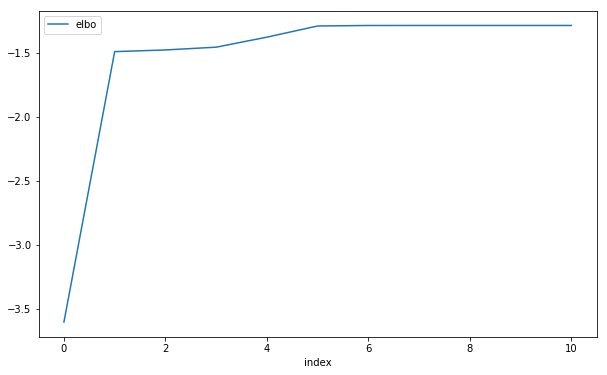

In [56]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,6)

pd.DataFrame(iter_elbo, columns=['elbo']).reset_index().plot.line(x="index", y="elbo")

,beta[0],beta[1],beta[2],e_lam[0],e_lam[1],e_lam[2]
0,0.084,0.530,0.052,0.000,0.579,0.041
1,0.001,0.008,0.000,0.000,0.010,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000
3,0.050,0.002,0.011,0.063,0.003,0.001
4,0.035,0.079,0.385,0.000,0.033,0.460
5,0.736,0.000,0.196,0.927,0.006,0.079
6,0.054,0.337,0.010,0.001,0.363,0.000
7,0.013,0.007,0.073,0.008,0.000,0.086
8,0.024,0.032,0.273,0.000,0.000,0.333
9,0.001,0.005,0.000,0.000,0.006,0.000


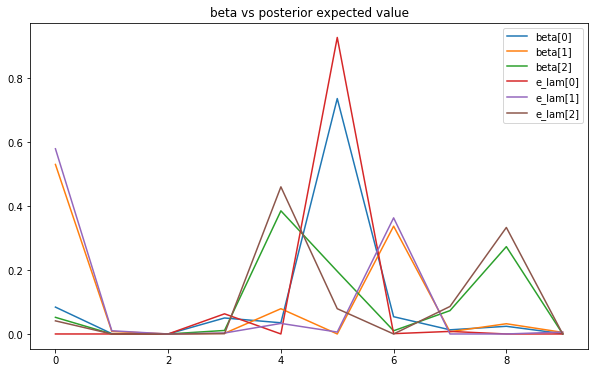

In [72]:
tmp1 = pd.DataFrame(np.round((tf.transpose(lam) / tf.reduce_sum(lam, axis=1)).numpy(), decimals=3),
                   columns=['beta[0]', 'beta[1]', 'beta[2]'])
tmp2 = pd.DataFrame(np.round(np.transpose(beta), decimals=3),
                  columns=['e_lam[0]', 'e_lam[1]', 'e_lam[2]'])
pd.concat([tmp1, tmp2], axis=1).plot.line(title="beta vs posterior expected value")
pd.concat([tmp1, tmp2], axis=1)

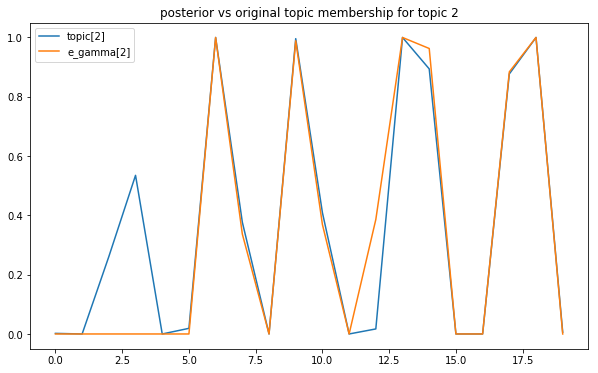

In [79]:
tmp1 = pd.DataFrame(np.round(theta[0:20, 1], decimals=3), columns=['topic[2]'])
tmp2 = pd.DataFrame(tf.transpose(gamma / tf.reduce_sum(gamma, axis=0)).numpy()[0:20, 1], columns=['e_gamma[2]'])

pd.concat([tmp1, tmp2], axis=1).plot.line(title="posterior vs original topic membership for topic 2")

### Calculate results for visualisation of topics

https://pyldavis.readthedocs.io/en/latest/modules/API.html#pyLDAvis.prepare

In [82]:
# topic term distribution:
topic_term_dist = (tf.transpose(tf.transpose(lam) / tf.reduce_sum(lam, axis=1))).numpy()
print(topic_term_dist.shape)

# doc_topic_dists :array-like, shape (n_docs, n_topics)
doc_topic_dist = tf.transpose(gamma / tf.reduce_sum(gamma, axis=0)).numpy()
print(doc_topic_dist.shape)

# # doc_lengths :array-like, shape n_docs
doc_len = tf.reduce_sum(nw, axis=0)
doc_len = doc_len.numpy()
print(doc_len.shape)

# # vocab :array-like, shape n_terms
vocab = np.array(list(range(V)))
print(vocab.shape)

# # term_frequency :array-like, shape n_terms
term_frec = tf.reduce_sum(nw, axis=1)
term_frec = term_frec.numpy()
print(term_frec.shape)

(3, 10)
(1000, 3)
(1000,)
(10,)
(10,)


In [83]:
import pyLDAvis
topics = pyLDAvis.prepare(topic_term_dist, doc_topic_dist, doc_len, vocab, term_frec)

/Users/qba/.local/share/virtualenvs/LDA-pHQnYWLy/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [84]:
pyLDAvis.save_html(topics, fileobj="results.html")

### Case study

#### Data Set Information:

The dataset is in the form of a 11463 x 5812 matrix of word counts, containing 11463 words and 5811 NIPS conference papers (the first column contains the list of words). Each column contains the number of times each word appears in the corresponding document. The names of the columns give information about each document and its timestamp in the following format: Xyear_paperID. 

The matrix of word counts was obtained using the R package 'tmâ€ to process the raw .txt files of the full text of the NIPS conference papers published between 1987 and 2015. The document-term matrix was constructed after tokenization, removal of stopwords and truncation of the vocabulary by only keeping words occurring more than 50 times.



In [17]:
import pandas as pd

In [18]:
data = pd.read_csv("NIPS_1987-2015.csv")

In [19]:
nw = np.array(data.iloc[:, 1:])
nw = nw.astype('float32')
nw = nw.transpose()

In [20]:
nw = tf.convert_to_tensor(nw)
# nw = nw[0:1000, :]
nw = tf.transpose(nw)

In [21]:
K = 10
V, D = nw.shape

In [85]:
nw_kvd = tf.tile(tf.expand_dims(nw / tf.reduce_sum(nw), axis=0), 
                 multiples=[K, 1, 1])

In [23]:
eta, alpha, lam, phi, gamma, e_log_beta, e_log_theta = initialize_variables(K, V, D, alpha=1e-3, eta=1e-3)

In [86]:
elbo(phi, e_log_beta, e_log_theta, nw_kvd)

-1.2821758

In [ ]:
max_iter = 10
max_iter_e_step = 10

prev_elbo = 0.0
next_elbo = 0.0
iter = 0

import time
start = time.time()

for i in range(max_iter):
    
    for j in range(max_iter_e_step):
        # E-Step:
        update_e_log_beta(e_log_beta, lam);
        update_e_log_theta(e_log_theta, gamma);
        update_phi(e_log_theta=e_log_theta, e_log_beta=e_log_beta)
        gamma_prev = gamma.value()
        update_gamma(gamma, alpha, phi, nw)
        diff = tf.reduce_mean(tf.abs(gamma_prev - gamma.value()))
        if diff < 1e-3:
            break
    
    # M-Step:
    update_lambda(lam, eta, phi, nw)
    
    
    next_elbo = elbo(phi, e_log_beta, e_log_theta, nw_kvd)
    print("Iteration:", iter, "ELBO:", next_elbo)
    
    
    diff = np.abs(next_elbo - prev_elbo)
    if diff < 1e-6:
        print("Converged!")
        break
    else:
        iter += 1
        prev_elbo = next_elbo

        
end = time.time()
print(end - start)

In [454]:
# topic term distribution:
topic_term_dist = (tf.transpose(tf.transpose(lam) / tf.reduce_sum(lam, axis=1))).numpy()
print(topic_term_dist.shape)

# doc_topic_dists :array-like, shape (n_docs, n_topics)
doc_topic_dist = tf.transpose(gamma / tf.reduce_sum(gamma, axis=0)).numpy()
print(doc_topic_dist.shape)

# # doc_lengths :array-like, shape n_docs
doc_len = tf.reduce_sum(nw, axis=0)
doc_len = doc_len.numpy()
print(doc_len.shape)

# # vocab :array-like, shape n_terms
vocab = data.iloc[:, 0].values
print(vocab.shape)

# # term_frequency :array-like, shape n_terms
term_frec = tf.reduce_sum(nw, axis=1)
term_frec = term_frec.numpy()
print(term_frec.shape)

In [455]:
import pyLDAvis
topics = pyLDAvis.prepare(topic_term_dist, doc_topic_dist, doc_len, vocab, term_frec)
pyLDAvis.save_html(topics, fileobj="results2.html")

/Users/qba/.local/share/virtualenvs/LDA-pHQnYWLy/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
